Task: Estimate the number of Nigerians that don’t have access to grid power.

Citations:
[Exploring raster and vector geographic data with rasterio and geopandas by  ELGUILLE](http://www.guilles.website/2018/06/12/tutorial-exploring-raster-and-vector-geographic-data-with-rasterio-and-geopandas/)

In [1]:
# Import necessary packages
import pandas as pd
import geopandas as gpd
import gdal
import seaborn as sns
import rasterio
from rasterio import mask
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
%matplotlib inline

In [2]:
# Read in grid data
grid = gpd.read_file("data/nigeria_at_03-08-2018.geojson")

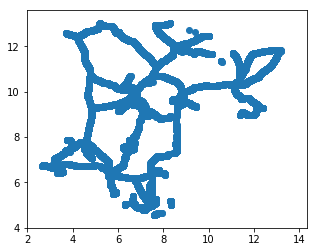

In [3]:
# Visualize what is in the grid data
grid.plot()

In [4]:
# Read in the Nigerian population data from CEISIN.
wpgt_file = "data/hrsl_nga_v1/hrsl_nga_pop.tif"
wpgt_r = rasterio.open(wpgt_file)
wpgt = wpgt_r.read()

In [5]:
# Make sure all pixel values are 0 or above (negative population doesn't make sense)
wpgt[wpgt<0] = 0

In [6]:
# Rasterize the geojson grid data in order to compare to the population data in raster form.
rasterizado = rasterio.features.rasterize(
    [(x.geometry, 1) for i, x in grid.iterrows()],
    out_shape=wpgt_r.shape,
    transform=wpgt_r.transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.uint8, )

In [7]:
# Write the rasterized map to a file, using the profile from the
# Nigerian population raster file to keep format in sync.
profile = wpgt_r.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw', 
    nodata=0)
rasterizado[rasterizado < 1] = 0
with rasterio.open("data/hrsl_nga_v1/hrsl_nga_pop_100x100m.tif", 'w', **profile) as out:
    out.write_band(1, rasterizado)

In [8]:
# Read the rasterized map back in. Wrote to file and
# loaded because cannot do in memory.
grid_raster = rasterio.open("data/hrsl_nga_v1/hrsl_nga_pop_100x100m.tif", 'r')
grid_raster_r = grid_raster.read()

In [9]:
# Create a mask from the grid raster file to use
# to select pixels in the population file to count.
# Selecting an area of about 200-300m from grid.
grid_filtered = ndi.maximum_filter(grid_raster_r, size = 5 )

In [10]:
# Use the mask to get the population that lives at ~ 300m or less from a grid. 
# To get the populations of the cells with 1, multiply the 
# Nigerian pop band by the grid filtered band:
grid_access = wpgt[0] * grid_filtered[0]

In [ ]:
plt.rcParams['figure.figsize'] = 14, 14
# Transform the data with the log10 function because it has a wide range
# and cells with low population count become invisible without rescaling.
plt.imshow(np.log10((np.fmax( grid_access+1, 1))), vmin = 0, interpolation="bilinear")
bar = plt.colorbar(fraction=0.03)